Check Data Distribution: Ensure the dataset is balanced among the categories. A skewed distribution can cause the model to predict the most frequent class.
Increase Dropout: To help with overfitting, especially given your issue with converging on a single class.
Modify the Transformer Setup: Adjust parameters like the number of heads and layers, especially if your model complexity doesn't match the task complexity.
Learning Rate Scheduler: Implement a scheduler to adjust the learning rate during training, which can help in better convergence.
Model Regularization: Consider adding batch normalization layers to stabilize the learning process.
Increase Epochs: As suggested by your TA, increasing the number of training epochs might help, but first ensure that the model architecture and learning rate are optimally set.

In [16]:
from socket import gethostname
gethostname()

'hpc3-gpu-24-01'

In [17]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [18]:
# Define transformations and load datasets
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

class_counts = {"angry": 3995, "disgust": 436, "fear": 4097, "happy": 7215, "neutral": 4965, "sad": 4830, "surprise":3171}

weights = [1.0 / counts for counts in class_counts.values()]
labels = train_dataset.classes
sample_weights = [weights[label] for _, label in train_dataset.samples]

# Create sampler and DataLoader for training
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, sampler=sampler, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the model and move it to device
class FERModel(nn.Module):
    def __init__(self):
        super(FERModel, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Increased percentage dropped to combat overfitting
            nn.Dropout(0.5)
        )
        self.output_layer = nn.Linear(256*3*3, 7)

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 256*3*3)
        x = self.output_layer(x)
        return x

# Initialize model, optimizer, loss function, and scheduler
model = FERModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Lists to store metrics
train_losses = []
val_losses = []
train_acc = []
val_acc = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_acc.append(correct / total)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = total_val_loss / len(test_loader.dataset)
    val_losses.append(avg_val_loss)
    val_acc.append(correct / total)


    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}, Train Acc: {train_acc[-1]}, Val Acc: {val_acc[-1]}')



Using device: cuda


Epoch 1/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.70it/s]


Epoch 1, Train Loss: 1.8225173855854337, Val Loss: 1.5633500908768985, Train Acc: 0.31969068933087186, Val Acc: 0.39439955419336864


Epoch 2/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:53<00:00, 16.75it/s]


Epoch 2, Train Loss: 1.4726829475409609, Val Loss: 1.3450486500238634, Train Acc: 0.4490926190393256, Val Acc: 0.4962385065477849


Epoch 3/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:53<00:00, 16.91it/s]


Epoch 3, Train Loss: 1.314699791372082, Val Loss: 1.2744920013109666, Train Acc: 0.509108641889303, Val Acc: 0.5136528280858178


Epoch 4/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:54<00:00, 16.48it/s]


Epoch 4, Train Loss: 1.2005732345948121, Val Loss: 1.209641003515701, Train Acc: 0.5522310076979344, Val Acc: 0.5405405405405406


Epoch 5/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:54<00:00, 16.51it/s]


Epoch 5, Train Loss: 1.1457332754015546, Val Loss: 1.1904553353670215, Train Acc: 0.5723988992998711, Val Acc: 0.5470883254388409


Epoch 6/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:55<00:00, 16.17it/s]


Epoch 6, Train Loss: 1.0855174529033003, Val Loss: 1.1690895992522454, Train Acc: 0.592218468076213, Val Acc: 0.5621342992477013


Epoch 7/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 16.97it/s]


Epoch 7, Train Loss: 1.0390790272557942, Val Loss: 1.1671552474816287, Train Acc: 0.6113065589188059, Val Acc: 0.5612984118138757


Epoch 8/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 17.23it/s]


Epoch 8, Train Loss: 0.9947101370103806, Val Loss: 1.0997809695812213, Train Acc: 0.6278867254171165, Val Acc: 0.589997213708554


Epoch 9/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:51<00:00, 17.36it/s]


Epoch 9, Train Loss: 0.9611384116260853, Val Loss: 1.1039270004810282, Train Acc: 0.6380229196419241, Val Acc: 0.5938980217330733


Epoch 10/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.70it/s]


Epoch 10, Train Loss: 0.9245078557420164, Val Loss: 1.123605347304133, Train Acc: 0.6561357065728517, Val Acc: 0.5886040679855112


Epoch 11/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.80it/s]


Epoch 11, Train Loss: 0.9090460480856063, Val Loss: 1.0777407560915826, Train Acc: 0.6616392072172489, Val Acc: 0.5948732237392031


Epoch 12/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.81it/s]


Epoch 12, Train Loss: 0.8752423266166305, Val Loss: 1.0924428547448386, Train Acc: 0.6728552022014003, Val Acc: 0.591111730286988


Epoch 13/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.75it/s]


Epoch 13, Train Loss: 0.8633469550573629, Val Loss: 1.0806048832445565, Train Acc: 0.679786826430736, Val Acc: 0.6062970186681527


Epoch 14/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.71it/s]


Epoch 14, Train Loss: 0.8524522446974421, Val Loss: 1.084219204462747, Train Acc: 0.6823295830575777, Val Acc: 0.6078294789634996


Epoch 15/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:53<00:00, 16.74it/s]


Epoch 15, Train Loss: 0.8353694647165454, Val Loss: 1.0901142834919546, Train Acc: 0.6899578529381031, Val Acc: 0.6081081081081081


Epoch 16/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 16.96it/s]


Epoch 16, Train Loss: 0.8021710993225554, Val Loss: 1.0719476925335278, Train Acc: 0.7064683548712947, Val Acc: 0.6115909724157147


Epoch 17/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 17.25it/s]


Epoch 17, Train Loss: 0.782719645298712, Val Loss: 1.054523934508207, Train Acc: 0.7072346650876032, Val Acc: 0.6125661744218446


Epoch 18/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.70it/s]


Epoch 18, Train Loss: 0.7746428834669077, Val Loss: 1.0807323798757305, Train Acc: 0.7130864885575952, Val Acc: 0.6157704095848425


Epoch 19/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:52<00:00, 17.02it/s]


Epoch 19, Train Loss: 0.755799274857488, Val Loss: 1.0660789801686479, Train Acc: 0.7207844230032394, Val Acc: 0.6214823070493174


Epoch 20/20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:50<00:00, 17.80it/s]


Epoch 20, Train Loss: 0.7488543879157834, Val Loss: 1.0555738660577745, Train Acc: 0.7225957016963321, Val Acc: 0.6174421844524938


In [19]:
print(model)

FERModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.5, inplace=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming test_loader is your DataLoader for the test dataset
true_labels = []
predicted_labels = []
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average="weighted")
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')


Overall Accuracy: 0.6174
F1 Score: 0.6132


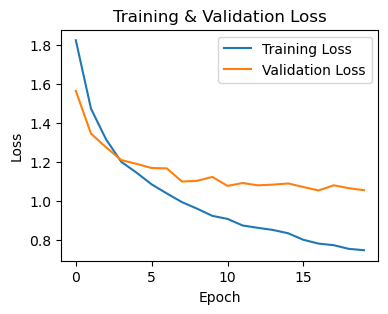

In [21]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

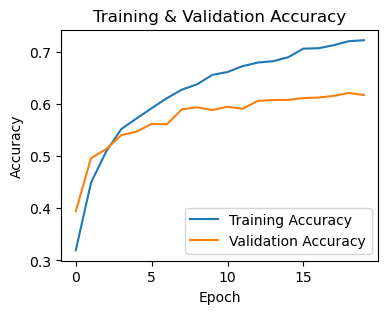

In [22]:
# Plotting the training and validation losses and learning rate
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

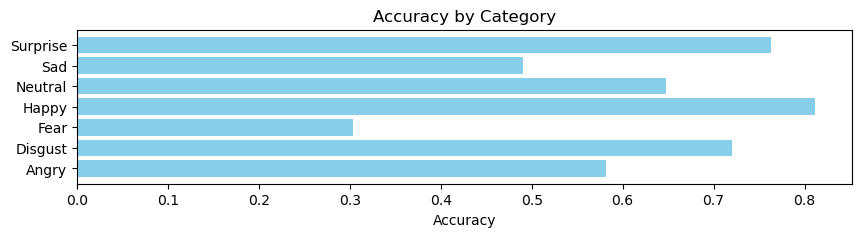

In [23]:
import numpy as np

category_accuracies = []
for i in range(7):
    category_mask = (np.array(true_labels) == i)
    category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
    category_accuracies.append(category_acc)

# Plotting category accuracies
categories = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
ax.barh(range(7), category_accuracies, color='skyblue')
ax.set_xlabel('Accuracy')
ax.set_yticks(range(7))
ax.set_yticklabels(categories)
ax.set_title('Accuracy by Category')
plt.show()

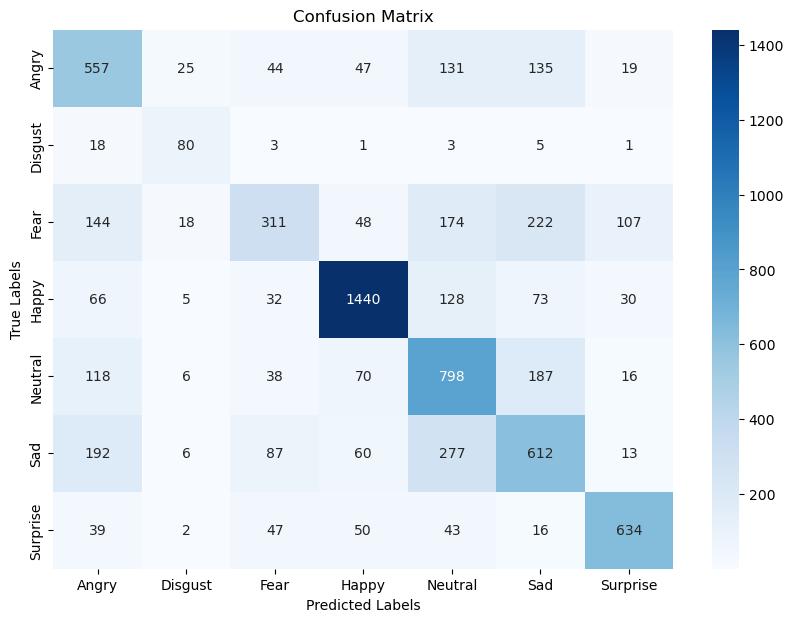

In [24]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
